In [1]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
pip install chardet

In [3]:
# Import necessary libraries
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification
from datasets import load_dataset, DatasetDict
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import pandas as pd
import os

In [4]:
# Load tokenizer and pre-trained model
tokenizer = AutoTokenizer.from_pretrained("lakshyakh93/deberta_finetuned_pii")
model = AutoModelForTokenClassification.from_pretrained("lakshyakh93/deberta_finetuned_pii")

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/78.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/6.31k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/555M [00:00<?, ?B/s]

In [5]:
# # Load the mini dataset (200 row)
# import chardet

# filepath = os.path.join(os.getcwd(), 'mini_df_200_row_biolabels.csv')

# # Detect encoding
# with open(filepath, 'rb') as f:
#     result = chardet.detect(f.read())
#     print("Detected file encoding:", result['encoding'])

# # Read the file using the detected encoding
# mini_df = pd.read_csv(filepath, encoding=result['encoding'])

# # Proportional split ratios
# train_ratio = 0.7
# val_ratio = 0.15
# test_ratio = 0.15

# # Since you have 200 rows, no need for the 3,000 cap, as this won't be needed
# train_size = int(len(mini_df) * train_ratio)
# val_size = int(len(mini_df) * val_ratio)
# test_size = len(mini_df) - train_size - val_size  # Remaining rows for the test set

# # Split the dataset into train, validation, and test sets
# train_df, temp_df = train_test_split(mini_df, test_size=1 - train_ratio, random_state=42)
# val_df, test_df = train_test_split(temp_df, test_size=test_ratio / (test_ratio + val_ratio), random_state=42)

# # Print dataset sizes to confirm
# print(f"Training size: {len(train_df)}")
# print(f"Validation size: {len(val_df)}")
# print(f"Test size: {len(test_df)}")

In [6]:
# # For the cleaned mini dataframe
# # Create a mapping for the bio_labels
# data_label_list = []

# # Extract unique labels from the 'bio_labels' column
# def get_unique_labels(df):
#     unique_labels = set()
#     for labels in df['bio_labels']:  # Iterate through the 'bio_labels' column
#         # Since bio_labels is a string representation of a list, we need to convert it back to a list
#         labels = eval(labels)  # Convert the string to a list
#         unique_labels.update(labels)  # Add all labels in the current row to the set
#     return sorted(unique_labels)  # Return sorted labels for consistency

# # Apply the function to the entire DataFrame
# unique_labels = get_unique_labels(mini_df)  # Run on the whole DataFrame

# # Print the unique labels
# print("Data's Unique BIO Labels:", unique_labels)

# # Combine with the existing label_list (if applicable)
# data_label_list = sorted(set(data_label_list + unique_labels))  # Ensure no duplicates
# print("Data's Final Label List:", data_label_list)
# print(len(data_label_list))  # Number of unique labels

# data_label_to_id = {label: idx for idx, label in enumerate(data_label_list)}
# data_id_to_label = {idx: label for label, idx in data_label_to_id.items()}

In [7]:
# Calculate the proportional sizes
total_samples = 15000
train_ratio = 7
val_ratio = 1.5
test_ratio = 1.5

total_ratio = train_ratio + val_ratio + test_ratio

train_size = int(total_samples * (train_ratio / total_ratio))
val_size = int(total_samples * (val_ratio / total_ratio))
test_size = total_samples - train_size - val_size

# Load dataset
dataset = load_dataset("Isotonic/pii-masking-200k")

# First, split off the test and validation sets
first_split = dataset["train"].train_test_split(test_size=(val_size + test_size)/len(dataset["train"]), seed=42)

# Then split the remaining data into train
train_split = first_split["train"].shuffle(seed=42).select(range(train_size))
val_test_split = first_split["test"].shuffle(seed=42).select(range(val_size + test_size))
val_split = val_test_split.select(range(val_size))
test_split = val_test_split.select(range(val_size, val_size + test_size))

# Create the final DatasetDict
dataset_splits = DatasetDict({
    "train": train_split,
    "validation": val_split,
    "test": test_split
})

print(f"Training size: {len(dataset_splits['train'])}")
print(f"Validation size: {len(dataset_splits['validation'])}")
print(f"Test size: {len(dataset_splits['test'])}")

README.md:   0%|          | 0.00/12.9k [00:00<?, ?B/s]

(…)-00000-of-00001-71c6cfc74148fe46.parquet:   0%|          | 0.00/115M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/209261 [00:00<?, ? examples/s]

Training size: 10500
Validation size: 2250
Test size: 2250


In [8]:
# Convert test_dataset into a dataframe
pii200k_train = dataset_splits['train'].to_pandas()
pii200k_val = dataset_splits['test'].to_pandas()
pii200k_test = dataset_splits['test'].to_pandas()

eng_train = pii200k_train[pii200k_train['language'] == 'en']
eng_val = pii200k_val[pii200k_val['language'] == 'en']
eng_test = pii200k_test[pii200k_test['language'] == 'en']

print(len(eng_train))
print(len(eng_val))
print(len(eng_test))

2120
478
478


In [9]:
# Filter rows where 'bio_labels' is not null (though unlikely given your data)
valid_eng_train = eng_train[eng_train['bio_labels'].notnull()]
valid_eng_val = eng_val[eng_val['bio_labels'].notnull()]
valid_eng_test = eng_test[eng_test['bio_labels'].notnull()]

import numpy as np
import re

def clean_bio_labels(bio_labels):
    # Flatten the numpy array of bio_labels and remove any non-printable characters
    bio_labels = [label for label in bio_labels.flatten() if isinstance(label, str)]
    cleaned_labels = [re.sub(r'[^\x20-\x7E]', '', label) for label in bio_labels]
    return cleaned_labels

# Apply the cleaning function to each bio_labels entry
eng_train['bio_labels'] = eng_train['bio_labels'].apply(clean_bio_labels)
eng_val['bio_labels'] = eng_val['bio_labels'].apply(clean_bio_labels)
eng_test['bio_labels'] = eng_test['bio_labels'].apply(clean_bio_labels)

# Check the resulting DataFrame
print(f"Number of valid rows in eng_train: {len(eng_train)}")
print(f"Number of valid rows in eng_val: {len(eng_val)}")
print(f"Number of valid rows in eng_test: {len(eng_test)}")

Number of valid rows in eng_train: 2120
Number of valid rows in eng_val: 478
Number of valid rows in eng_test: 478


<ipython-input-9-a54fa4498df2>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eng_train['bio_labels'] = eng_train['bio_labels'].apply(clean_bio_labels)
<ipython-input-9-a54fa4498df2>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eng_val['bio_labels'] = eng_val['bio_labels'].apply(clean_bio_labels)
<ipython-input-9-a54fa4498df2>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [10]:
data_label_list = []

# Extract unique BIO labels
unique_labels = set()

# Iterate through the 'bio_labels' column
for labels in eng_train['bio_labels']:
    unique_labels.update(labels)  # Add all unique labels from each array

# Convert to sorted list for consistency
unique_labels = sorted(unique_labels)

print("Data's Unique BIO Labels:", unique_labels)
print(f"Number of unique labels: {len(unique_labels)}")

# Combine with the existing label_list (if applicable)
data_label_list = sorted(set(data_label_list + unique_labels))  # Ensure no duplicates
print("Data's Final Label List:", data_label_list)
print(len(data_label_list))  # Number of unique labels

data_label_to_id = {label: idx for idx, label in enumerate(data_label_list)}
data_id_to_label = {idx: label for label, idx in data_label_to_id.items()}

Data's Unique BIO Labels: ['B-ACCOUNTNAME', 'B-ACCOUNTNUMBER', 'B-AGE', 'B-AMOUNT', 'B-BIC', 'B-BITCOINADDRESS', 'B-BUILDINGNUMBER', 'B-CITY', 'B-COMPANYNAME', 'B-COUNTY', 'B-CREDITCARDCVV', 'B-CREDITCARDISSUER', 'B-CREDITCARDNUMBER', 'B-CURRENCY', 'B-CURRENCYCODE', 'B-CURRENCYNAME', 'B-CURRENCYSYMBOL', 'B-DATE', 'B-DOB', 'B-EMAIL', 'B-ETHEREUMADDRESS', 'B-EYECOLOR', 'B-FIRSTNAME', 'B-GENDER', 'B-HEIGHT', 'B-IBAN', 'B-IP', 'B-IPV4', 'B-IPV6', 'B-JOBAREA', 'B-JOBTITLE', 'B-JOBTYPE', 'B-LASTNAME', 'B-LITECOINADDRESS', 'B-MAC', 'B-MASKEDNUMBER', 'B-MIDDLENAME', 'B-NEARBYGPSCOORDINATE', 'B-ORDINALDIRECTION', 'B-PASSWORD', 'B-PHONEIMEI', 'B-PHONENUMBER', 'B-PIN', 'B-PREFIX', 'B-SECONDARYADDRESS', 'B-SEX', 'B-SSN', 'B-STATE', 'B-STREET', 'B-TIME', 'B-URL', 'B-USERAGENT', 'B-USERNAME', 'B-VEHICLEVIN', 'B-VEHICLEVRM', 'B-ZIPCODE', 'I-ACCOUNTNAME', 'I-ACCOUNTNUMBER', 'I-AGE', 'I-AMOUNT', 'I-BIC', 'I-BITCOINADDRESS', 'I-BUILDINGNUMBER', 'I-CITY', 'I-COMPANYNAME', 'I-COUNTY', 'I-CREDITCARDCVV', '

In [11]:
model_label_list = model.config.id2label.values()  # Ensure this matches the fine-tuned model
model_id_to_label = {int(k): v for k, v in model.config.id2label.items()}
model_label_to_id = {v: int(k) for k, v in model_id_to_label.items()}

print("Model's Label to ID:", model_label_to_id)
print("Model's ID to Label:", model_id_to_label)
print(len(model_label_list))

Model's Label to ID: {'B-PREFIX': 0, 'I-PREFIX': 1, 'B-FIRSTNAME': 2, 'I-FIRSTNAME': 3, 'B-MIDDLENAME': 4, 'B-LASTNAME': 5, 'I-LASTNAME': 6, 'O': 7, 'B-JOBDESCRIPTOR': 8, 'B-JOBTITLE': 9, 'I-JOBTITLE': 10, 'B-COMPANY_NAME': 11, 'I-COMPANY_NAME': 12, 'B-JOBAREA': 13, 'B-EMAIL': 14, 'I-EMAIL': 15, 'B-TIME': 16, 'I-TIME': 17, 'B-DATE': 18, 'I-DATE': 19, 'B-URL': 20, 'I-URL': 21, 'B-BITCOINADDRESS': 22, 'I-BITCOINADDRESS': 23, 'B-ETHEREUMADDRESS': 24, 'I-ETHEREUMADDRESS': 25, 'B-ACCOUNTNAME': 26, 'I-ACCOUNTNAME': 27, 'B-IBAN': 28, 'I-IBAN': 29, 'B-ACCOUNTNUMBER': 30, 'I-ACCOUNTNUMBER': 31, 'B-BIC': 32, 'I-BIC': 33, 'B-IPV4': 34, 'I-IPV4': 35, 'B-STREETADDRESS': 36, 'I-STREETADDRESS': 37, 'B-CITY': 38, 'I-CITY': 39, 'B-ZIPCODE': 40, 'I-ZIPCODE': 41, 'B-USERNAME': 42, 'I-USERNAME': 43, 'B-IPV6': 44, 'I-IPV6': 45, 'B-CREDITCARDNUMBER': 46, 'I-CREDITCARDNUMBER': 47, 'B-VEHICLEVIN': 48, 'I-VEHICLEVIN': 49, 'B-SUFFIX': 50, 'I-SUFFIX': 51, 'B-AMOUNT': 52, 'I-AMOUNT': 53, 'B-CURRENCY': 54, 'I-CURR

In [12]:
# Define metrics calculation function
def compute_metrics(predictions, references):
    acc = accuracy_score(references, predictions)
    precision = precision_score(references, predictions, average="weighted", zero_division=1)
    recall = recall_score(references, predictions, average="weighted", zero_division=1)
    f1 = f1_score(references, predictions, average="weighted", zero_division=1)
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [13]:
from transformers import DataCollatorForTokenClassification
from torch.utils.data import DataLoader
import numpy as np

def tokenize_and_align_labels(df, tokenizer, data_label_to_id, model_label_to_id):
    def normalize_label(label):
        # Remove suffixes like "_1", "_2"
        if "_" in label and label.split("_")[-1].isdigit():
            return "_".join(label.split("_")[:-1])
        return label

    def map_labels_to_model(data_label):
        normalized_label = normalize_label(data_label)  # Normalize dataset labels
        return model_label_to_id.get(normalized_label, model_label_to_id.get("O", -100))  # Default to "O"

    # Tokenize input text
    tokenized_inputs = tokenizer(
        list(df["unmasked_text"]),  # Convert Series to list of strings
        truncation=True,
        padding=True,
        max_length=512,
        return_tensors="pt",
        is_split_into_words=False,
    )

    labels = []
    for i, label_seq in enumerate(df["bio_labels"]):
        word_labels = eval(label_seq) if isinstance(label_seq, str) else label_seq  # Convert string back to list if needed
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens back to words
        token_labels = []
        for word_id in word_ids:
            if word_id is None:  # Special tokens
                token_labels.append(-100)
            elif word_id < len(word_labels):  # Ensure within bounds
                token_labels.append(map_labels_to_model(word_labels[word_id]))
            else:
                token_labels.append(-100)  # Ignore out-of-bounds tokens
        labels.append(token_labels)

    tokenized_inputs["labels"] = torch.tensor(labels)
    return tokenized_inputs

# Tokenize the training set
tokenized_train = tokenize_and_align_labels(eng_train, tokenizer, data_label_to_id, model_label_to_id)
# Create a DataLoader for the training set
train_dataset = torch.utils.data.TensorDataset(tokenized_train["input_ids"], tokenized_train["attention_mask"], tokenized_train["labels"])
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)

# Tokenize the validation set
tokenized_val = tokenize_and_align_labels(eng_val, tokenizer, data_label_to_id, model_label_to_id)
# Create a DataLoader for the validation set
val_dataset = torch.utils.data.TensorDataset(tokenized_val["input_ids"], tokenized_val["attention_mask"], tokenized_val["labels"])
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Tokenize the test set
tokenized_test = tokenize_and_align_labels(eng_test, tokenizer, data_label_to_id, model_label_to_id)
# Create a DataLoader for the test set
test_dataset = torch.utils.data.TensorDataset(tokenized_test["input_ids"], tokenized_test["attention_mask"], tokenized_test["labels"])
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [14]:
for key, value in tokenized_train.items():
    print(f"{key}: {value.shape}")

for key, value in tokenized_val.items():
    print(f"{key}: {value.shape}")

for key, value in tokenized_test.items():
    print(f"{key}: {value.shape}")

input_ids: torch.Size([2120, 140])
token_type_ids: torch.Size([2120, 140])
attention_mask: torch.Size([2120, 140])
labels: torch.Size([2120, 140])
input_ids: torch.Size([478, 137])
token_type_ids: torch.Size([478, 137])
attention_mask: torch.Size([478, 137])
labels: torch.Size([478, 137])
input_ids: torch.Size([478, 137])
token_type_ids: torch.Size([478, 137])
attention_mask: torch.Size([478, 137])
labels: torch.Size([478, 137])


In [15]:
id_to_label = {v: k for k, v in model_label_to_id.items()}

In [16]:
# # Find the optimized hyperparameters

# import optuna

# def objective(trial):
#     # Suggest hyperparameters
#     batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
#     temperature = trial.suggest_float("temperature", 0.5, 2.0)
#     use_fp16 = trial.suggest_categorical("use_fp16", [True, False])

#     # Configure inference settings
#     all_predictions, all_references = [], []
#     model.eval()

#     with torch.no_grad():
#         for batch in test_dataloader:
#             input_ids, attention_mask, labels = [t.to(device) for t in batch]

#             # Mixed precision inference
#             with torch.cuda.amp.autocast(enabled=use_fp16):
#                 outputs = model(input_ids, attention_mask=attention_mask)
#                 logits = outputs.logits / temperature  # Apply temperature scaling

#             # Get predictions
#             predictions = torch.argmax(logits, dim=-1).cpu().numpy()
#             labels = labels.cpu().numpy()

#             # Align predictions and references to only include non-special tokens
#             for pred, label in zip(predictions, labels):
#                 true_labels = [id_to_label[l] for l in label if l != -100]
#                 pred_labels = [
#                     id_to_label.get(p, "O") for p, l in zip(pred, label) if l != -100
#                 ]
#                 all_predictions.extend(pred_labels)
#                 all_references.extend(true_labels)

#     # Calculate metrics
#     metrics = compute_metrics(all_predictions, all_references)
#     return metrics["f1"]  # Optimize for F1 score

# # Hyperparameter optimization with Optuna
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=20)

# # Display the best hyperparameters
# print("Best hyperparameters:", study.best_params)

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
from torch.optim import AdamW
from transformers import get_scheduler
from torch.cuda.amp import GradScaler, autocast

# Initialize lists to store loss and metrics
train_losses = []
val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1_scores = []

# Early stopping parameters
patience = 3  # Number of epochs to wait for improvement
best_val_metric = float('-inf')  # Initialize best metric as negative infinity
epochs_without_improvement = 0  # Counter for no improvement

# Initialize GradScaler for mixed precision
scaler = GradScaler()

# Define optimizer and scheduler
optimizer = AdamW([
    {"params": model.deberta.encoder.layer[:6].parameters(), "lr": 1e-5},  # Lower LR for bottom layers
    {"params": model.deberta.encoder.layer[6:].parameters(), "lr": 2e-5},  # Higher LR for top layers
    {"params": model.classifier.parameters(), "lr": 2e-5},  # Classifier head
])
num_epochs = 10
num_training_steps = len(train_dataloader) * num_epochs
num_warmup_steps = int(0.1 * num_training_steps)

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_training_steps)

# Freezing the first 6 layers of the encoder
for name, param in model.named_parameters():
    # Check if the parameter belongs to the encoder's layers
    if "deberta.encoder.layer" in name:
        try:
            layer_num = int(name.split(".")[3])  # Extract layer number
            if layer_num < 6:  # Freeze the first 6 layers
                param.requires_grad = False
        except ValueError:
            # Ignore parameters that don't follow the expected format
            continue
    else:
        # Leave other parameters trainable (e.g., classifier)
        param.requires_grad = True

# Check which layers are trainable
trainable_params = [name for name, param in model.named_parameters() if param.requires_grad]
print(f"Trainable parameters: {trainable_params}")

# Training and validation loop
model.train()
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    total_loss = 0
    step = 0

    # Training loop
    for batch in train_dataloader:
        input_ids, attention_mask, labels = [t.to(device) for t in batch]

        with autocast():  # Updated autocast usage
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        lr_scheduler.step()

        if step % 10 == 0:  # Log every 10 steps
            avg_loss = total_loss / (step + 1)
            print(f"Step {step}/{len(train_dataloader)}, Loss: {loss.item()}, Avg Loss: {avg_loss}")

        step += 1

    # Calculate average training loss
    avg_train_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch + 1} Training Loss: {avg_train_loss}")

    # Validation loop
    model.eval()
    val_loss = 0
    all_predictions, all_references = [], []
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids, attention_mask, labels = [t.to(device) for t in batch]
            with autocast():
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                val_loss += loss.item()

            predictions = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
            labels = labels.cpu().numpy()

            # Process predictions and references
            for pred, label in zip(predictions, labels):
                true_labels = [id_to_label[l] for l in label if l != -100]
                pred_labels = [id_to_label.get(p, "O") for p, l in zip(pred, label) if l != -100]
                all_predictions.extend(pred_labels)
                all_references.extend(true_labels)

    # Compute validation metrics
    avg_val_loss = val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
    metrics = compute_metrics(all_predictions, all_references)
    print(f"Validation Metrics: {metrics}")
    val_accuracies.append(metrics['accuracy'])
    val_precisions.append(metrics['precision'])
    val_recalls.append(metrics['recall'])
    val_f1_scores.append(metrics['f1'])

    print(f"Validation Metrics: {metrics}")
    print(f"Epoch {epoch + 1} Validation Loss: {avg_val_loss}")
    # Early stopping logic
    val_metric = metrics['f1']  # Use F1 score as the metric to monitor
    if val_metric > best_val_metric:
        best_val_metric = val_metric
        epochs_without_improvement = 0
        print("Validation F1 improved. Saving model...")
        torch.save(model.state_dict(), "best_deberta.pth")  # Save best model
    else:
        epochs_without_improvement += 1
        print(f"No improvement for {epochs_without_improvement} epoch(s).")

    if epochs_without_improvement >= patience:
        print("Early stopping triggered.")
        break

    model.train()  # Return to training mode

Trainable parameters: ['deberta.embeddings.word_embeddings.weight', 'deberta.embeddings.LayerNorm.weight', 'deberta.embeddings.LayerNorm.bias', 'deberta.encoder.layer.6.attention.self.q_bias', 'deberta.encoder.layer.6.attention.self.v_bias', 'deberta.encoder.layer.6.attention.self.in_proj.weight', 'deberta.encoder.layer.6.attention.self.pos_proj.weight', 'deberta.encoder.layer.6.attention.self.pos_q_proj.weight', 'deberta.encoder.layer.6.attention.self.pos_q_proj.bias', 'deberta.encoder.layer.6.attention.output.dense.weight', 'deberta.encoder.layer.6.attention.output.dense.bias', 'deberta.encoder.layer.6.attention.output.LayerNorm.weight', 'deberta.encoder.layer.6.attention.output.LayerNorm.bias', 'deberta.encoder.layer.6.intermediate.dense.weight', 'deberta.encoder.layer.6.intermediate.dense.bias', 'deberta.encoder.layer.6.output.dense.weight', 'deberta.encoder.layer.6.output.dense.bias', 'deberta.encoder.layer.6.output.LayerNorm.weight', 'deberta.encoder.layer.6.output.LayerNorm.bias

<ipython-input-17-eac591985c4f>:21: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-17-eac591985c4f>:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated autocast usage


Step 0/67, Loss: 4.688714504241943, Avg Loss: 4.688714504241943
Step 10/67, Loss: 2.798820734024048, Avg Loss: 3.3143314881758257
Step 20/67, Loss: 1.8041630983352661, Avg Loss: 2.7892402978170487
Step 30/67, Loss: 1.190187931060791, Avg Loss: 2.415025149622271
Step 40/67, Loss: 1.3745912313461304, Avg Loss: 2.1446033309145673
Step 50/67, Loss: 0.9767328500747681, Avg Loss: 1.9494506705041026
Step 60/67, Loss: 0.9908398985862732, Avg Loss: 1.7989905046634986
Epoch 1 Training Loss: 1.7229064195903379


<ipython-input-17-eac591985c4f>:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Metrics: {'accuracy': 0.7353149327671621, 'precision': 0.7172754931323045, 'recall': 0.7353149327671621, 'f1': 0.7061110386457271}
Validation Metrics: {'accuracy': 0.7353149327671621, 'precision': 0.7172754931323045, 'recall': 0.7353149327671621, 'f1': 0.7061110386457271}
Epoch 1 Validation Loss: 0.991032334168752
Validation F1 improved. Saving model...

Epoch 2/10


<ipython-input-17-eac591985c4f>:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated autocast usage


Step 0/67, Loss: 1.100433588027954, Avg Loss: 1.100433588027954
Step 10/67, Loss: 0.9451817870140076, Avg Loss: 0.9630973068150607
Step 20/67, Loss: 0.7048472166061401, Avg Loss: 0.917140319233849
Step 30/67, Loss: 0.7451959252357483, Avg Loss: 0.9058700338486703
Step 40/67, Loss: 0.9174474477767944, Avg Loss: 0.8884247744955668
Step 50/67, Loss: 0.6850915551185608, Avg Loss: 0.8640243855177188
Step 60/67, Loss: 0.7719559073448181, Avg Loss: 0.8422304020553338
Epoch 2 Training Loss: 0.8319896112627058


<ipython-input-17-eac591985c4f>:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Metrics: {'accuracy': 0.7642368483132814, 'precision': 0.7577581567560862, 'recall': 0.7642368483132814, 'f1': 0.7484647205118058}
Validation Metrics: {'accuracy': 0.7642368483132814, 'precision': 0.7577581567560862, 'recall': 0.7642368483132814, 'f1': 0.7484647205118058}
Epoch 2 Validation Loss: 0.7777541359265645
Validation F1 improved. Saving model...

Epoch 3/10


<ipython-input-17-eac591985c4f>:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated autocast usage


Step 0/67, Loss: 0.8702497482299805, Avg Loss: 0.8702497482299805
Step 10/67, Loss: 0.702214241027832, Avg Loss: 0.7370870059186762
Step 20/67, Loss: 0.554996907711029, Avg Loss: 0.7229284644126892
Step 30/67, Loss: 0.6128390431404114, Avg Loss: 0.7195463661224611
Step 40/67, Loss: 0.7944594025611877, Avg Loss: 0.7153368170668439
Step 50/67, Loss: 0.6565236449241638, Avg Loss: 0.702828376900916
Step 60/67, Loss: 0.6868137121200562, Avg Loss: 0.6914210993735517
Epoch 3 Training Loss: 0.683843140281848


<ipython-input-17-eac591985c4f>:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Metrics: {'accuracy': 0.775654635527247, 'precision': 0.7613057013729218, 'recall': 0.775654635527247, 'f1': 0.7584546260628456}
Validation Metrics: {'accuracy': 0.775654635527247, 'precision': 0.7613057013729218, 'recall': 0.775654635527247, 'f1': 0.7584546260628456}
Epoch 3 Validation Loss: 0.6983027815818786
Validation F1 improved. Saving model...

Epoch 4/10


<ipython-input-17-eac591985c4f>:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated autocast usage


Step 0/67, Loss: 0.7874354720115662, Avg Loss: 0.7874354720115662
Step 10/67, Loss: 0.6269218921661377, Avg Loss: 0.6530404361811551
Step 20/67, Loss: 0.49746841192245483, Avg Loss: 0.6422467487198966
Step 30/67, Loss: 0.6024627089500427, Avg Loss: 0.6446482808359207
Step 40/67, Loss: 0.7252123951911926, Avg Loss: 0.6432110652690981
Step 50/67, Loss: 0.6008409857749939, Avg Loss: 0.6345133430817548
Step 60/67, Loss: 0.6232872009277344, Avg Loss: 0.6254918648571265
Epoch 4 Training Loss: 0.6192521395078346


<ipython-input-17-eac591985c4f>:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Metrics: {'accuracy': 0.782826138240151, 'precision': 0.7691600060339981, 'recall': 0.782826138240151, 'f1': 0.7658122699585953}
Validation Metrics: {'accuracy': 0.782826138240151, 'precision': 0.7691600060339981, 'recall': 0.782826138240151, 'f1': 0.7658122699585953}
Epoch 4 Validation Loss: 0.6627115488052369
Validation F1 improved. Saving model...

Epoch 5/10


<ipython-input-17-eac591985c4f>:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated autocast usage


Step 0/67, Loss: 0.721605658531189, Avg Loss: 0.721605658531189
Step 10/67, Loss: 0.5800508856773376, Avg Loss: 0.5992150631817904
Step 20/67, Loss: 0.438357949256897, Avg Loss: 0.5915799112547011
Step 30/67, Loss: 0.5487509965896606, Avg Loss: 0.5961646014644254
Step 40/67, Loss: 0.709847092628479, Avg Loss: 0.5992309262112874
Step 50/67, Loss: 0.5763325095176697, Avg Loss: 0.5910650631960701
Step 60/67, Loss: 0.6061049699783325, Avg Loss: 0.5854430100956901
Epoch 5 Training Loss: 0.58022424756591


<ipython-input-17-eac591985c4f>:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Metrics: {'accuracy': 0.7867893371078084, 'precision': 0.770644359169891, 'recall': 0.7867893371078084, 'f1': 0.7699227503848385}
Validation Metrics: {'accuracy': 0.7867893371078084, 'precision': 0.770644359169891, 'recall': 0.7867893371078084, 'f1': 0.7699227503848385}
Epoch 5 Validation Loss: 0.6403833369414011
Validation F1 improved. Saving model...

Epoch 6/10


<ipython-input-17-eac591985c4f>:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated autocast usage


Step 0/67, Loss: 0.6718461513519287, Avg Loss: 0.6718461513519287
Step 10/67, Loss: 0.5633794069290161, Avg Loss: 0.566724798896096
Step 20/67, Loss: 0.43701082468032837, Avg Loss: 0.5629616436504182
Step 30/67, Loss: 0.5557403564453125, Avg Loss: 0.5695850224264206
Step 40/67, Loss: 0.648691713809967, Avg Loss: 0.5711360442929152
Step 50/67, Loss: 0.5260515213012695, Avg Loss: 0.5638687014579773
Step 60/67, Loss: 0.5808066129684448, Avg Loss: 0.5580409721272891
Epoch 6 Training Loss: 0.5539895531846516


<ipython-input-17-eac591985c4f>:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Metrics: {'accuracy': 0.7913187072422742, 'precision': 0.776188410044337, 'recall': 0.7913187072422742, 'f1': 0.7746863713200116}
Validation Metrics: {'accuracy': 0.7913187072422742, 'precision': 0.776188410044337, 'recall': 0.7913187072422742, 'f1': 0.7746863713200116}
Epoch 6 Validation Loss: 0.625516539812088
Validation F1 improved. Saving model...

Epoch 7/10


<ipython-input-17-eac591985c4f>:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated autocast usage


Step 0/67, Loss: 0.5982502698898315, Avg Loss: 0.5982502698898315
Step 10/67, Loss: 0.5185513496398926, Avg Loss: 0.5456711649894714
Step 20/67, Loss: 0.42040279507637024, Avg Loss: 0.5396477111748287
Step 30/67, Loss: 0.508573055267334, Avg Loss: 0.5477103379464918
Step 40/67, Loss: 0.6242449879646301, Avg Loss: 0.5487559823001303
Step 50/67, Loss: 0.4975287616252899, Avg Loss: 0.5412354258929982
Step 60/67, Loss: 0.5547968745231628, Avg Loss: 0.5372334982528061
Epoch 7 Training Loss: 0.5335692180626428


<ipython-input-17-eac591985c4f>:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Metrics: {'accuracy': 0.7940552016985138, 'precision': 0.7802960951668266, 'recall': 0.7940552016985138, 'f1': 0.7779382805569606}
Validation Metrics: {'accuracy': 0.7940552016985138, 'precision': 0.7802960951668266, 'recall': 0.7940552016985138, 'f1': 0.7779382805569606}
Epoch 7 Validation Loss: 0.6154797673225403
Validation F1 improved. Saving model...

Epoch 8/10


<ipython-input-17-eac591985c4f>:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated autocast usage


Step 0/67, Loss: 0.6400246024131775, Avg Loss: 0.6400246024131775
Step 10/67, Loss: 0.5215736031532288, Avg Loss: 0.5368475047024813
Step 20/67, Loss: 0.3868885338306427, Avg Loss: 0.530455292690368
Step 30/67, Loss: 0.49888166785240173, Avg Loss: 0.5347647974568028
Step 40/67, Loss: 0.6387615203857422, Avg Loss: 0.5371642287184553
Step 50/67, Loss: 0.5059971213340759, Avg Loss: 0.5304944012679306
Step 60/67, Loss: 0.5408802628517151, Avg Loss: 0.5265142644037966
Epoch 8 Training Loss: 0.5225528870055924


<ipython-input-17-eac591985c4f>:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Metrics: {'accuracy': 0.7949516395376268, 'precision': 0.7825129822993693, 'recall': 0.7949516395376268, 'f1': 0.7797985027881816}
Validation Metrics: {'accuracy': 0.7949516395376268, 'precision': 0.7825129822993693, 'recall': 0.7949516395376268, 'f1': 0.7797985027881816}
Epoch 8 Validation Loss: 0.6108591775099437
Validation F1 improved. Saving model...

Epoch 9/10


<ipython-input-17-eac591985c4f>:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated autocast usage


Step 0/67, Loss: 0.6012774705886841, Avg Loss: 0.6012774705886841
Step 10/67, Loss: 0.4871161878108978, Avg Loss: 0.5196657072414052
Step 20/67, Loss: 0.41292357444763184, Avg Loss: 0.5188957694030943
Step 30/67, Loss: 0.5103428363800049, Avg Loss: 0.525840962125409
Step 40/67, Loss: 0.6228329539299011, Avg Loss: 0.5276713785601825
Step 50/67, Loss: 0.49450448155403137, Avg Loss: 0.5207168161869049
Step 60/67, Loss: 0.5481357574462891, Avg Loss: 0.5170629713378969
Epoch 9 Training Loss: 0.5132694880464184


<ipython-input-17-eac591985c4f>:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Metrics: {'accuracy': 0.7966973342769521, 'precision': 0.7838751579288109, 'recall': 0.7966973342769521, 'f1': 0.7813043508366188}
Validation Metrics: {'accuracy': 0.7966973342769521, 'precision': 0.7838751579288109, 'recall': 0.7966973342769521, 'f1': 0.7813043508366188}
Epoch 9 Validation Loss: 0.6082800447940826
Validation F1 improved. Saving model...

Epoch 10/10


<ipython-input-17-eac591985c4f>:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated autocast usage


Step 0/67, Loss: 0.6059463620185852, Avg Loss: 0.6059463620185852
Step 10/67, Loss: 0.4728071391582489, Avg Loss: 0.5194164866750891
Step 20/67, Loss: 0.4083307385444641, Avg Loss: 0.5177293774627504
Step 30/67, Loss: 0.4954615831375122, Avg Loss: 0.5239134017498263
Step 40/67, Loss: 0.6224483847618103, Avg Loss: 0.5279152691364288
Step 50/67, Loss: 0.48151829838752747, Avg Loss: 0.5211663737016565
Step 60/67, Loss: 0.5498925447463989, Avg Loss: 0.5171577710597242
Epoch 10 Training Loss: 0.5131701529026031


<ipython-input-17-eac591985c4f>:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Metrics: {'accuracy': 0.7959424392545411, 'precision': 0.7843348745315567, 'recall': 0.7959424392545411, 'f1': 0.781208925632011}
Validation Metrics: {'accuracy': 0.7959424392545411, 'precision': 0.7843348745315567, 'recall': 0.7959424392545411, 'f1': 0.781208925632011}
Epoch 10 Validation Loss: 0.6102343718210856
No improvement for 1 epoch(s).


In [ ]:
from google.colab import files

# Download the saved model file
files.download("best_deberta.pth")

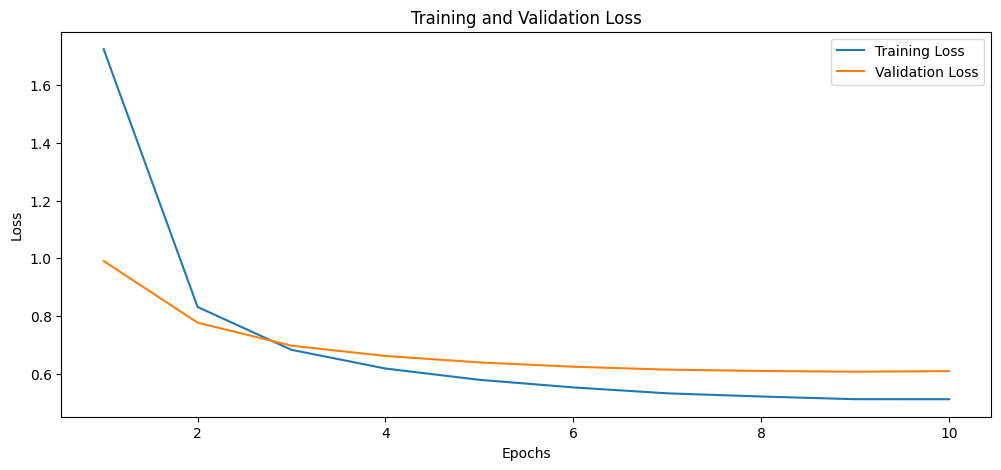

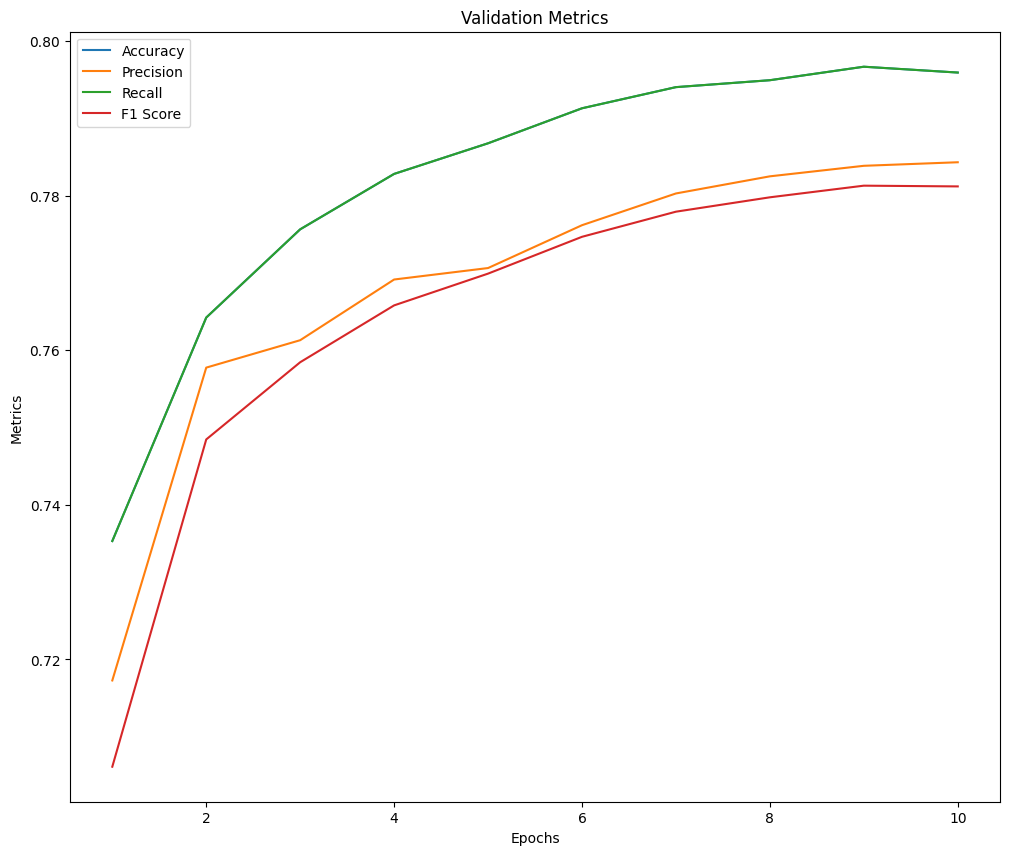

In [19]:
# Visualization
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.plot(epochs, train_losses, label="Training Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot validation metrics
plt.figure(figsize=(12, 10))
plt.plot(epochs, val_accuracies, label="Accuracy")
plt.plot(epochs, val_precisions, label="Precision")
plt.plot(epochs, val_recalls, label="Recall")
plt.plot(epochs, val_f1_scores, label="F1 Score")
plt.title("Validation Metrics")
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.legend()
plt.show()

In [22]:
# Inference loop using the optimized hyperparameters
all_predictions, all_references = [], []
model.load_state_dict(torch.load("best_deberta.pth"))
model.to(device)

with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, labels = [t.to(device) for t in batch]

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits / 0.9989592666538125  # Use optimized temperature

        # Get predictions
        predictions = torch.argmax(logits, dim=-1).cpu().numpy()
        labels = labels.cpu().numpy()

        # Align predictions and references to only include non-special tokens
        for pred, label in zip(predictions, labels):
            true_labels = [
                id_to_label[l] for l in label if l != -100
            ]  # Convert ground truth IDs to labels
            pred_labels = [
                id_to_label.get(p, "O") for p, l in zip(pred, label) if l != -100
            ]  # Convert predictions to labels, defaulting to "O" for unmapped IDs

            all_predictions.extend(pred_labels)
            all_references.extend(true_labels)

# Calculate metrics
metrics = compute_metrics(all_predictions, all_references)
print("Test metrics:", metrics)

<ipython-input-22-156a83ab9707>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_deberta.pth"))


Test metrics: {'accuracy': 0.7984430290162774, 'precision': 0.778581869077181, 'recall': 0.7984430290162774, 'f1': 0.7752615324265881}


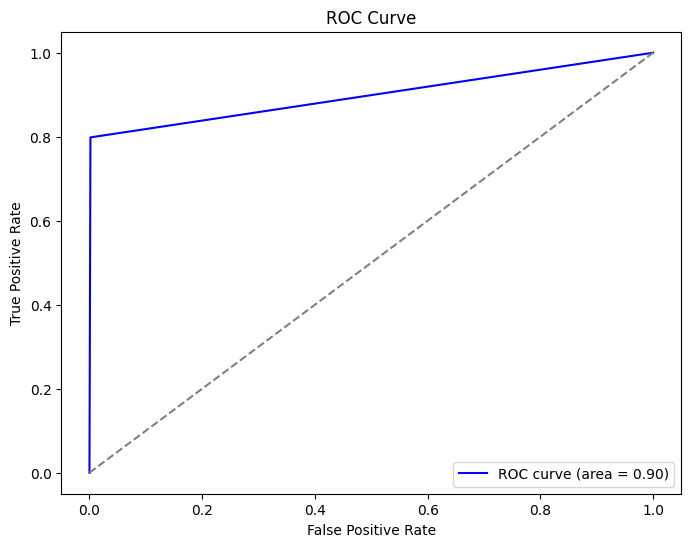

In [24]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize your true and predicted labels (use label_binarize for multilabel)
true_binary = label_binarize(all_references, classes=list(id_to_label.values()))
pred_binary = label_binarize(all_predictions, classes=list(id_to_label.values()))

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(true_binary.ravel(), pred_binary.ravel())
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [23]:
from sklearn.decomposition import PCA
import numpy as np

# Extract the unique classes from all_references and all_predictions
unique_labels = sorted(set(all_references) | set(all_predictions))
display_labels = [id_to_label[label] for label in unique_labels]

# Plot the confusion matrix with consistent labels
ConfusionMatrixDisplay.from_predictions(
    all_references,
    all_predictions,
    display_labels=display_labels
)
plt.title("Confusion Matrix (Filtered Labels)")
plt.show()

KeyError: 'B-ACCOUNTNAME'

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(all_references, all_predictions, output_dict=True)
df = pd.DataFrame(report).transpose()

# Plot F1 scores for each label
df["f1-score"].plot(kind="bar", figsize=(12, 6))
plt.title("F1 Score by Label")
plt.ylabel("F1 Score")
plt.xlabel("Labels")
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import numpy as np

cm = confusion_matrix(all_references, all_predictions)
misclassified_indices = np.unravel_index(np.argsort(-cm, axis=None), cm.shape)
top_misclassifications = [
    (id_to_label[misclassified_indices[0][i]], id_to_label[misclassified_indices[1][i]], cm[misclassified_indices[0][i], misclassified_indices[1][i]])
    for i in range(10)  # Top 10 misclassifications
]

for true, predicted, count in top_misclassifications:
    print(f"True: {true}, Predicted: {predicted}, Count: {count}")

# Extract unique indices for the top misclassifications
unique_indices = list(set([misclassified_indices[0][i] for i in range(10)] +
                          [misclassified_indices[1][i] for i in range(10)]))

# Create a subset confusion matrix
subset_cm = cm[np.ix_(unique_indices, unique_indices)]
subset_labels = [list(id_to_label.values())[i] for i in unique_indices]

# Plot the subset confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=subset_cm, display_labels=subset_labels)
disp.plot(cmap="viridis", xticks_rotation="vertical", colorbar=True)
plt.title("Confusion Matrix For Top Misclassifications)")
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

# Convert string labels to numeric IDs using id_to_label reverse mapping
label_to_id_reverse = {label: idx for idx, label in id_to_label.items()}

# Map predictions and references to numeric IDs
numeric_predictions = [label_to_id_reverse[label] for label in all_predictions]
numeric_references = [label_to_id_reverse[label] for label in all_references]

# Choose the label ID of interest (e.g., for binary classification, the positive class)
pos_label_id = label_to_id_reverse["B-CREDITCARDNUMBER"]  # Replace "B-YOUR_LABEL" with your target class

# Compute precision-recall curve
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

precision, recall, _ = precision_recall_curve(numeric_references, numeric_predictions, pos_label=pos_label_id)

# Plot the Precision-Recall curve
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.title("Precision-Recall Curve")
plt.show()

# Flatten predictions and references for multiclass handling (if applicable)
# Note: This works best for binary or one-vs-all analysis.
# Example below assumes binary or flattened labels.
precision, recall, _ = precision_recall_curve(numeric_references, numeric_predictions, pos_label="B-CREDITCARDNUMBER")

# Display Precision-Recall curve
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.title("Precision-Recall Curve")
plt.show()
